[MA-7] VAL RMSE: 3424.65 | RMSPE: 0.3030
Epoch 01 | Val RMSPE=0.9034
Epoch 02 | Val RMSPE=0.6622
Epoch 03 | Val RMSPE=0.6318
Epoch 04 | Val RMSPE=0.5930
Epoch 05 | Val RMSPE=0.5246
Epoch 06 | Val RMSPE=0.4521
Epoch 07 | Val RMSPE=0.3966
Epoch 08 | Val RMSPE=0.3531
Epoch 09 | Val RMSPE=0.3190
Epoch 10 | Val RMSPE=0.2950
Epoch 11 | Val RMSPE=0.2785
Epoch 12 | Val RMSPE=0.2651
Epoch 13 | Val RMSPE=0.2544
Epoch 14 | Val RMSPE=0.2465
Epoch 15 | Val RMSPE=0.2414
Epoch 16 | Val RMSPE=0.2368
Epoch 17 | Val RMSPE=0.2335
Epoch 18 | Val RMSPE=0.2313
Epoch 19 | Val RMSPE=0.2298
Epoch 20 | Val RMSPE=0.2281
Epoch 21 | Val RMSPE=0.2270
Epoch 22 | Val RMSPE=0.2262
Epoch 23 | Val RMSPE=0.2257
Epoch 24 | Val RMSPE=0.2252
Epoch 25 | Val RMSPE=0.2248

[LIN-MAIN] VAL RMSPE: 0.22482527792453766
[LIN-MAIN] TEST RMSPE: 0.204807311296463


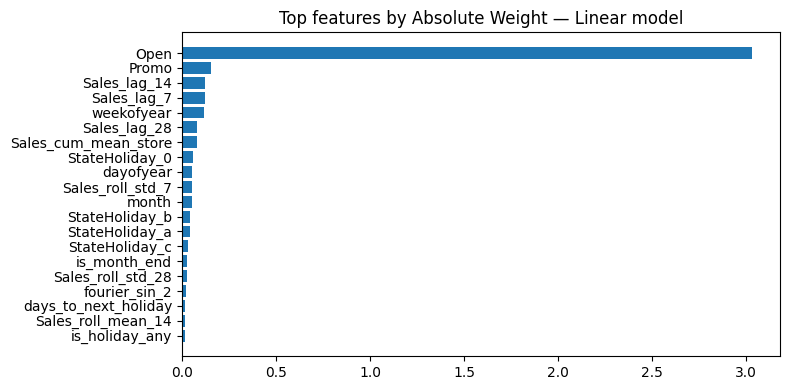


--- Skipping Grid Search (Using pre-computed optimal parameters from the grid) ---
Training final XGBoost model with params: {'max_depth': 8, 'eta': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.7, 'objective': 'reg:squarederror', 'disable_default_eval_metric': 1}
[0]	train-rmspe:0.74620	val-rmspe:0.76009
[50]	train-rmspe:0.21828	val-rmspe:0.16924
[100]	train-rmspe:0.20358	val-rmspe:0.12472
[150]	train-rmspe:0.19891	val-rmspe:0.12144
[200]	train-rmspe:0.18100	val-rmspe:0.11836
[250]	train-rmspe:0.17439	val-rmspe:0.11775
[300]	train-rmspe:0.16295	val-rmspe:0.11788
[317]	train-rmspe:0.16218	val-rmspe:0.11774

[XGB] FINAL TEST RMSPE: 0.11071033775806427


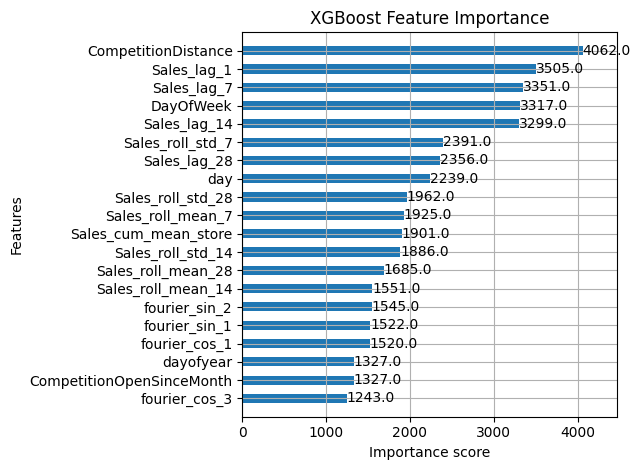

In [1]:
# =========================
# Phase 3 — Learn & Estimate (Rossmann) [UPDATED: RMSPE, Log-Reversal & Auto Grid Search]
# =========================

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PHASE2_DIR = "artifacts/phase2"
TRAIN_F = os.path.join(PHASE2_DIR, "train_features.csv")
VAL_F   = os.path.join(PHASE2_DIR, "val_features.csv")
TEST_F  = os.path.join(PHASE2_DIR, "test_features.csv")
FEAT_F  = os.path.join(PHASE2_DIR, "feature_cols.json")
META_F  = os.path.join(PHASE2_DIR, "split_meta.json")

assert os.path.exists(TRAIN_F), "train_features.csv not found. Run Phase 2 first."

with open(FEAT_F, "r", encoding="utf-8") as f:
    feature_cols = json.load(f)["feature_cols"]

with open(META_F, "r", encoding="utf-8") as f:
    split_meta = json.load(f)

if "Store" in feature_cols:
    feature_cols = [c for c in feature_cols if c != "Store"]

# ---------- Load CSVs ----------
NROWS_DEBUG = None

train_df = pd.read_csv(TRAIN_F, nrows=NROWS_DEBUG)
val_df   = pd.read_csv(VAL_F,   nrows=NROWS_DEBUG)
test_df  = pd.read_csv(TEST_F,  nrows=NROWS_DEBUG)

def ensure_store_id(df):
    df["Date"] = pd.to_datetime(df["Date"])
    s = pd.to_numeric(df["Store"], errors="coerce")
    df["Store"] = np.round(s).astype(int)
    return df

train_df = ensure_store_id(train_df)
val_df   = ensure_store_id(val_df)
test_df  = ensure_store_id(test_df)

TARGET = "Sales"
META_COLS = ["Store", "Date"]

def to_xy(df):
    X = df[feature_cols].to_numpy(dtype=np.float32)
    y = df[TARGET].to_numpy(dtype=np.float32) 
    return X, y

X_train, y_train = to_xy(train_df)
X_val,   y_val   = to_xy(val_df)
X_test,  y_test  = to_xy(test_df)

# =========================
# Metrics (No Sklearn) - FIXED FOR LOG & RMSPE
# =========================

def rmspe(y_true, y_pred):
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)
    
    mask = y_true > 0
    if not np.any(mask): return 0.0
    
    rmspe_val = np.sqrt(np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2))
    return float(rmspe_val)

def rmse(y_true, y_pred):
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

# =========================
# Baseline 1 — Moving Average (from raw train.csv)
# =========================
def moving_average_baseline_from_raw(raw_train_csv="train.csv", window=7):
    raw = pd.read_csv(raw_train_csv, low_memory=False) 
    raw["Date"] = pd.to_datetime(raw["Date"])
    raw = raw.sort_values(["Store", "Date"])
    g = raw.groupby("Store")["Sales"]
    raw["ma_pred"] = g.shift(1).rolling(window=window, min_periods=max(2, window//2)).mean().reset_index(level=0, drop=True)
    return raw[["Store", "Date", "ma_pred"]]

ma_tbl = moving_average_baseline_from_raw("train.csv", window=7)

def eval_baseline_ma(split_df, name="VAL"):
    tmp = split_df[["Store","Date","Sales"]].merge(ma_tbl, on=["Store","Date"], how="left")
    
    y_true_real = np.expm1(tmp["Sales"].to_numpy())
    store_mean = tmp.groupby("Store")["Sales"].transform(lambda x: np.expm1(x).mean())
    tmp["ma_pred"] = tmp["ma_pred"].fillna(store_mean).fillna(y_true_real.mean())
    
    y_pred_real = tmp["ma_pred"].to_numpy()
    
    y_true_log = np.log1p(y_true_real)
    y_pred_log = np.log1p(y_pred_real)
    
    print(f"[MA-7] {name} RMSE: {rmse(y_true_log, y_pred_log):.2f} | RMSPE: {rmspe(y_true_log, y_pred_log):.4f}")
    return tmp

ma_val = eval_baseline_ma(val_df, "VAL")

# =========================
# Baseline 2 — Linear Regression (from scratch, GD + Ridge)
# =========================
class LinearRegressionGD:
    def __init__(self, lr=0.01, epochs=30, batch_size=8192, l2=0.0, seed=42, verbose=1):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.l2 = l2
        self.seed = seed
        self.verbose = verbose
        self.w = None
        self.b = 0.0

    def fit(self, X, y, X_val=None, y_val=None):
        n, d = X.shape
        rng = np.random.default_rng(self.seed)
        self.w = rng.normal(0, 0.01, size=(d,)).astype(np.float32)
        self.b = 0.0

        best_val = float("inf")
        best_params = (self.w.copy(), float(self.b))

        for ep in range(1, self.epochs + 1):
            idx = rng.permutation(n)
            Xs = X[idx]; ys = y[idx]

            for i in range(0, n, self.batch_size):
                xb = Xs[i:i+self.batch_size]
                yb = ys[i:i+self.batch_size]
                pred = xb @ self.w + self.b
                err = pred - yb
                gw = (xb.T @ err) / len(xb)
                gb = float(np.mean(err))

                if self.l2 > 0: gw = gw + self.l2 * self.w

                self.w -= self.lr * gw
                self.b -= self.lr * gb

            if X_val is not None:
                val_pred = self.predict(X_val)
                val_rmspe = rmspe(y_val, val_pred)
                if val_rmspe < best_val:
                    best_val = val_rmspe
                    best_params = (self.w.copy(), float(self.b))
                if self.verbose:
                    print(f"Epoch {ep:02d} | Val RMSPE={val_rmspe:.4f}")

        if X_val is not None:
            self.w, self.b = best_params
        return self

    def predict(self, X):
        return (X @ self.w + self.b).astype(np.float32)

lin_main = LinearRegressionGD(lr=0.01, epochs=25, batch_size=8192, l2=1e-4, verbose=1)
lin_main.fit(X_train, y_train, X_val, y_val)

pred_val_lin = lin_main.predict(X_val)
pred_test_lin = lin_main.predict(X_test)

print("\n[LIN-MAIN] VAL RMSPE:", rmspe(y_val, pred_val_lin))
print("[LIN-MAIN] TEST RMSPE:", rmspe(y_test, pred_test_lin))

# =========================
# Feature Importance for Linear Model
# =========================
w = lin_main.w.astype(np.float64)
imp_df = pd.DataFrame({"feature": feature_cols, "importance": np.abs(w)}).sort_values("importance", ascending=False)

topk = 20
plt.figure(figsize=(8,4))
plt.barh(imp_df["feature"].head(topk)[::-1], imp_df["importance"].head(topk)[::-1])
plt.title("Top features by Absolute Weight — Linear model")
plt.tight_layout()
plt.show()

# =========================
# XGBoost Model & Hyperparameter Tuning
# =========================

try:
    import xgboost as xgb
    import itertools
    
    def rmspe_xgb(y_pred, dtrain):
        y_true = dtrain.get_label()
        y_true_exp = np.expm1(y_true)
        y_pred_exp = np.expm1(y_pred)
        
        mask = y_true_exp > 0
        if not np.any(mask): return 'rmspe', 0.0
        
        err = np.sqrt(np.mean(((y_true_exp[mask] - y_pred_exp[mask]) / y_true_exp[mask]) ** 2))
        return 'rmspe', err

    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_cols)
    dval   = xgb.DMatrix(X_val,   label=y_val,   feature_names=feature_cols)
    dtest  = xgb.DMatrix(X_test,  label=y_test,  feature_names=feature_cols)

    # -----------------------------------------------------
    # 1. Define Search Space
    # -----------------------------------------------------
    param_grid = {
        'max_depth': [6, 8, 10],
        'eta': [0.01, 0.05, 0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.7]
    }
    
    keys, values = zip(*param_grid.items())
    grid_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    RUN_TUNING = False 
    
    if RUN_TUNING:
        print(f"\n--- Running Grid Search over {len(grid_combinations)} combinations ---")
        best_rmspe = float('inf')
        best_params = None
        
        for i, p in enumerate(grid_combinations):
            curr_params = {"objective": "reg:squarederror", "disable_default_eval_metric": 1, **p}
            
            bst_tune = xgb.train(curr_params, dtrain, num_boost_round=100, evals=[(dval, "val")],
                                 custom_metric=rmspe_xgb, early_stopping_rounds=20, verbose_eval=False)
            
            val_pred = bst_tune.predict(dval)
            y_true_val = np.expm1(y_val)
            y_pred_val = np.expm1(val_pred)
            mask = y_true_val > 0
            curr_rmspe = np.sqrt(np.mean(((y_true_val[mask] - y_pred_val[mask]) / y_true_val[mask]) ** 2))
            
            print(f"Comb {i+1}/{len(grid_combinations)} | {p} | Val RMSPE: {curr_rmspe:.4f}")
            if curr_rmspe < best_rmspe:
                best_rmspe = curr_rmspe
                best_params = p
                
        print(f"\n Grid Search Completed! Best Params: {best_params}")
    else:
        print("\n--- Skipping Grid Search (Using pre-computed optimal parameters from the grid) ---")
        best_params = {
            'max_depth': 8,
            'eta': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.7
        }

    # -----------------------------------------------------
    # 2. Final Model Training
    # -----------------------------------------------------
    best_params["objective"] = "reg:squarederror"
    best_params["disable_default_eval_metric"] = 1
    
    ev = [(dtrain,"train"), (dval,"val")]
    
    print("Training final XGBoost model with params:", best_params)
    bst = xgb.train(
        best_params, 
        dtrain, 
        num_boost_round=500, 
        evals=ev,
        custom_metric=rmspe_xgb, 
        early_stopping_rounds=30, 
        verbose_eval=50
    )
    
    pred_test_xgb = bst.predict(dtest)
    print("\n[XGB] FINAL TEST RMSPE:", rmspe(y_test, pred_test_xgb))
    
    # رسم Importance خود درخت
    xgb.plot_importance(bst, max_num_features=20, height=0.5)
    plt.title("XGBoost Feature Importance")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("XGB part failed or not installed:", e)